<a href="https://colab.research.google.com/github/mohit6199/CNN-experiments/blob/master/InceptionNet_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import keras
from keras.layers.core import Layer
import keras.backend as K
import tensorflow as tf
from keras.datasets import cifar10

Using TensorFlow backend.


In [0]:
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

import cv2 
import numpy as np 
from keras.datasets import cifar10 
from keras import backend as K 
from keras.utils import np_utils

import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

In [7]:
num_classes = 10

def load_cifar10_data(img_rows, img_cols):

    # Load cifar10 training and validation sets
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    index_train=[]
    for i in range(0,50000):
        if y_train[i]>5:
            index_train.append(i)
    x_train=np.delete(x_train,index_train,0)
    y_train=np.delete(y_train,index_train,0)

    print('x_train ' , x_train.shape)
    print('y_train ', y_train.shape)

    index_test=[]
    for i in range(0,10000):
        if y_test[i]>5:
            index_test.append(i)
    x_test=np.delete(x_test,index_test,0)
    y_test=np.delete(y_test,index_test,0)

    print('x_test ' , x_test.shape)
    print('y_test ', y_test.shape)
    #--------------------------------------------------------------------------
    ith_class={}
    for i in np.arange(0,6):
        ith_class[i]=[]
        
    ith_class_test={}
    for i in np.arange(0,6):
        ith_class_test[i]=[]
        
    for i in range(0,30000):
        ith_class[y_train[i][0]].append(i)
    for i in range(0,6000):
        ith_class_test[y_test[i][0]].append(i)

    delete_list=[]
    for i in np.arange(0,6):
        delete_list.append(ith_class[i][500:5000])
    x_train=np.delete(x_train,delete_list,0)
    y_train=np.delete(y_train,delete_list,0)

    print(x_train.shape)
    print(y_train.shape)

    delete_list_val=[]
    for i in np.arange(0,6):
        delete_list_val.append(ith_class_test[i][100:1000])
    x_test=np.delete(x_test,delete_list_val,0)
    y_test=np.delete(y_test,delete_list_val,0)

    print(x_test.shape)
    print(y_test.shape)

    # Resize training images
    x_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in x_train[:,:,:,:]])
    x_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in x_test[:,:,:,:]])

    # Transform targets to keras compatible format
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)
    
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    # preprocess data
    x_train = x_train / 255.0
    x_test = x_test / 255.0

    print(x_train.shape)

    return x_train, y_train, x_test, y_test


X_train, y_train, X_test, y_test = load_cifar10_data(224, 224)

x_train  (30000, 32, 32, 3)
y_train  (30000, 1)
x_test  (6000, 32, 32, 3)
y_test  (6000, 1)
(3000, 32, 32, 3)
(3000, 1)
(600, 32, 32, 3)
(600, 1)
(3000, 224, 224, 3)


In [0]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [0]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [10]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(10, activation='softmax', name='output')(x)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')

In [12]:
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 56, 56, 64)   4160        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

In [0]:
epochs = 100
initial_lrate = 0.0084 #the one we found optimal for AlexNet

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

In [16]:
history = model.fit(X_train, [y_train, y_train, y_train], validation_data=(X_test, [y_test, y_test, y_test]), epochs=epochs, batch_size=256, callbacks=[lr_sc])

Train on 3000 samples, validate on 600 samples
Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
3000/3000 [==============================] - 9s 3ms/step - loss: 2.6167 - output_loss: 1.6375 - auxilliary_output_1_loss: 1.6253 - auxilliary_output_2_loss: 1.6387 - output_acc: 0.3140 - auxilliary_output_1_acc: 0.3293 - auxilliary_output_2_acc: 0.3177 - val_loss: 2.5945 - val_output_loss: 1.6320 - val_auxilliary_output_1_loss: 1.5999 - val_auxilliary_output_2_loss: 1.6084 - val_output_acc: 0.3000 - val_auxilliary_output_1_acc: 0.3283 - val_auxilliary_output_2_acc: 0.3217
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.01.
3000/3000 [==============================] - 6s 2ms/step - loss: 2.5828 - output_loss: 1.6135 - auxilliary_output_1_loss: 1.6061 - auxilliary_output_2_loss: 1.6248 - output_acc: 0.3250 - auxilliary_output_1_acc: 0.3350 - auxilliary_output_2_acc: 0.3130 - val_loss: 2.5755 - val_output_loss: 1.6177 - val_auxilliary_out

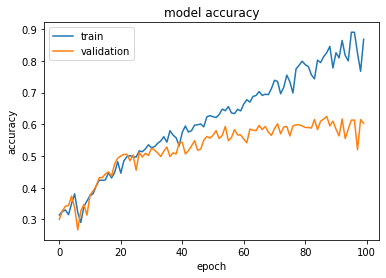

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['output_acc'])
plt.plot(history.history['val_output_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
